# Assignment-5

### Import necessary libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def splitTrainTest(data,percent):
    total=len(data)
    trainTotal=int(total*percent*0.01)
    testTotal=total-trainTotal
    return (data[0:trainTotal],data[trainTotal:total])

### Layer Class
This class's object represent the layers in neural network. It stores the number of neurons in each layers, activations, activation function associated with each layer and their weight vector (initialize on gaussian distribute with mean =0 and std deviation=1).

In [3]:
class Layer:
    def __init__(self,nNodesCurrent, nNodesNext, activationF):
        self.nodesNo=nNodesCurrent
        self.activations = np.zeros([nNodesCurrent,1])
        self.activationF=activationF
        if nNodesNext==0:
            self.weights=None
        else:
            self.weights=np.random.normal(0, 1, size=(nNodesCurrent,nNodesNext))

### Neural Network Class
Class of neural network to perform multiclass classification using the cross entropy as cost function and softmax as probabilty distribution activation function.

This class perform following tasks:
* Initialized the number of layers in neural network and create **Layer Class** object.
* Train the neural network on batches of inputs there by performing the forward and backward propogation using below helper methods.

#### Methods:
1. **Forward Propogation** : Perform the forward propogation, calculate and stores activations at each of the 
layer.
$$ z_1= w_1^TX $$
$$ a_1= f _1(z_1) $$
$$ z_2= w_2^Ta_1 $$
$$ \hat{y}= a_2= f_2(z_2) $$
2. **Calculate Error** : Here we calculate the cross entropy error of our neural network on the updated activations. This updation in activation take place after the updation of weights in gradient decent algorithm in backpropogation.
<br>
For multiclass classification we use the below cross entropy cost function:
$$ J =  -\sum\limits_{i} y \log \; \hat{y} $$
3. **Backward Propogation** : Here, we differentiate the cost function to minimize it, and find the optimal values of parameters ie weights at each of the layer.
$$\frac{\partial J}{\partial w_2 } =  \frac{\partial J}{\partial \hat{y} }  * \frac{\partial \hat{y}}{\partial z_2 }  * \frac{\partial z_2}{\partial w_2 }   $$
<br>
also for cross entropy as a cost function and softmax as $f_2(z_2)$ , 
$$ \delta_3  =  \frac{\partial J}{\partial \hat{y} }  * \frac{\partial \hat{y}}{\partial z_2 } = (y_p - y_a)  $$
<br>
$$ \therefore   \frac{\partial J}{\partial w_2 }= (\hat{y} - y) * a_1$$
<br><br>
Similarly to calculate parital derivative w.r.t weights of inner layers, we can use the chain rule
$$   \frac{\partial J}{\partial w_1 } = x^T *  \delta_3 *  w_2 *  f^1 (z_1)      $$

4. **Get Accuracy**: This function will return the accuracy of our neural network on multiclass classification.

<hr>

**Some important activations functions and their derivatives used in our network**
**Softmax**
<br>
$$\sigma (z)_j = \frac{e^{z_j}}{\sum^K_{k=1} e^{z_j}}$$
**Sigmoid**
<br>
$$sigmoid(x) = \frac{1}{1+\epsilon ^ {-x}}$$
$$\frac{\partial sigmoid(x)}{\partial x} = sigmoid(x) * ( 1- sigmoid(x))$$

**Relu**
<br>
$$relu(x) = \max{(0,x)}$$
<br>
$$\frac{\partial relu(x)}{\partial x} = 1 \;\;\;\; if x>0  \\ 0 \;\;\; elsewhere$$

**tanh**
<br>
$$tanh(x) = \tanh{(x)}$$
<br>
$$\frac{\partial tanh(x)}{\partial x} = 1 - \tanh^2{(x)}$$

In [30]:
class NeuralNet:
    def __init__(self, totalLayers, noNodesList, activationFunctions):
        self.totalLayers=totalLayers
        self.noNodesList=noNodesList
        self.layers = []
        for i in range(totalLayers):
            currentLayerNodes=noNodesList[i]
            if i!=totalLayers-1:
                nextLayerNodes=noNodesList[i+1]
                ith_Layer=Layer(currentLayerNodes,nextLayerNodes,activationFunctions[i])
            else:
                ith_Layer=Layer(currentLayerNodes,0,activationFunctions[i])
            self.layers.append(ith_Layer)#append output layer as none

    def trainNetwork(self, data,outputLabels, batchSize, epochs, learningRate,notforGraph=True):
        self.learningRate=learningRate
        self.batchSize=batchSize;
        
        #normalize data
#         data=((data-data.min(axis=0))/(data.max(axis=0)-data.min(axis=0)))
#         data=data/255
        
        for x in range(epochs):
            i=0  
            while i<len(data):
                self.error=0
                self.forwardPropo(data[i:i+batchSize])#input
                self.calculateError(outputLabels[i:i+batchSize])#output
                self.backwardPropo(outputLabels[i:i+batchSize])
                i+=batchSize
            self.error /= batchSize
            if notforGraph:
                print("Epoch ",x,"->Error: ", self.error)
        
          
    def forwardPropo(self, inputs):
        self.layers[0].activations =inputs
        for i in range(self.totalLayers-1):
            temp=np.matmul(self.layers[i].activations,self.layers[i].weights)  
            if self.layers[i+1].activationF == "sigmoid":
                self.layers[i+1].activations = self.sigmoid(temp)
            elif self.layers[i+1].activationF == "softmax":
                self.layers[i+1].activations = self.softmax(temp)
            elif self.layers[i+1].activationF == "relu":
                self.layers[i+1].activations = self.relu(temp)
            elif self.layers[i+1].activationF == "tanh":
                self.layers[i+1].activations = self.tanh(temp)
            else:
                self.layers[i+1].activations = temp
        
    def calculateError(self,labels):
        if len(labels[0]) != self.layers[self.totalLayers-1].nodesNo:
            print ("Error: Label is not of the same shape as output layer.")
            print("Label: ", len(labels), " : ", len(labels[0]))
            print("Out: ", len(self.layers[self.totalLayers-1].activations), " : ", len(self.layers[self.totalLayers-1].activations[0]))
            return
        self.error += np.negative(np.sum(np.multiply(labels, np.log(self.layers[self.totalLayers-1].activations))))
    
    def backwardPropo(self, labels):
        targets = labels
        i = self.totalLayers-1
        y = self.layers[i].activations
        
        delta=(y-targets)
        deltaw = np.dot(self.layers[i-1].activations.T, delta)/self.batchSize
        new_weights = self.layers[i-1].weights - self.learningRate * deltaw
        for i in range(i-1, 0, -1):
            if self.layers[i].activationF=="sigmoid":
                prime= self.sigmoid_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
            elif self.layers[i].activationF=="relu":
                prime= self.relu_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
            elif self.layers[i].activationF=="tanh":
                prime= self.tanh_derivative(np.matmul(self.layers[i-1].activations,self.layers[i-1].weights))
            
            delta=np.multiply(prime,delta.dot(self.layers[i].weights.T))
            deltaw = np.dot(self.layers[i-1].activations.T, delta)/self.batchSize

            self.layers[i].weights = new_weights
            new_weights = self.layers[i-1].weights - self.learningRate * deltaw
        self.layers[0].weights = new_weights
    
    def predict(self,inputs):
#         inputs=inputs/255
        self.batchSize = len(inputs)
        self.forwardPropo(inputs)
        a = self.layers[self.totalLayers-1].activations
        predictions=[]
        actuals=[]
        for i in range(len(a)):
            al=a[i].tolist()
            predictions.append(al.index(max(al)))
#             actuals.append(labels[i])
        
        a = np.array(predictions)
#         b = np.array(actuals)
#         df = pd.DataFrame({"predictions" : a, "actuals" : b})
        df = pd.DataFrame({"predictions" : a})
        df.to_csv("predictions.csv", index=False)

        
    def getAccuracy(self, inputs, labels, forGraph=False):
#         inputs=inputs/255
        self.batchSize = len(inputs)
        self.forwardPropo(inputs)
        a = self.layers[self.totalLayers-1].activations
#         print(len(a))
        total=0
        correct=0
        for i in range(len(a)):
            total += 1
            al = a[i].tolist()
            if labels[i][al.index(max(al))] == 1:
                correct += 1
#         print(correct)
        accuracy=correct*100/total
        print("Accuracy: ", accuracy)
        if forGraph:
            return accuracy
    
    def sigmoid(self, x):
        return np.divide(1, np.add(1, np.exp(np.negative(x))))
    
    def sigmoid_derivative(self,x):
        return (self.sigmoid(x)*(1-self.sigmoid(x)))
    
    def relu(self, x):
        return (x/700) * (x > 0)
    
    def relu_derivative(self,X):
        return 1. * (X > 0)
    
    def softmax(self, x):
        exp = np.exp(x)
        if isinstance(x[0], np.ndarray):
            return exp/np.sum(exp, axis=1, keepdims=True)
        else:
            return exp/np.sum(exp, keepdims=True)

    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self,x):
        return 1.0 - np.tanh(x) ** 2

In [5]:
def getOneHotLabels(data,k):
    one_hot_labels = np.zeros((len(data), k))
    for i in range(len(data)):  
        one_hot_labels[i,data[i,0]] = 1
    return one_hot_labels

In [6]:
data=pd.read_csv("../input/assignment5/apparel-trainval.csv").values
# testdata=pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv").values
testdata=pd.read_csv("../input/appareltesting/apparel-test.csv").values

### Question-1 Part-2

**Sigmoid**

In [ ]:
train,test=splitTrainTest(data,80)
oneHotLabelsTrain=getOneHotLabels(train,10)
oneHotLabelsTest=getOneHotLabels(test,10)
trainInputs=train[:,1:]
testInputs=test[:,1:]
print("Neural network with sigmoid activation function in hidden layers")

numberofLayers=4
noofneurons=[784,16,16,10]
activationFunctions=[None,"sigmoid","sigmoid","softmax"]
batchSize=64
epochs=50
learningRat=0.6
trainInputs=trainInputs/255
testInputs=testInputs/255

#NeuralNet(noLayers, noNeurons in each layer, activationFunctions)
nn=NeuralNet(numberofLayers,noofneurons,activationFunctions)
nn.trainNetwork(trainInputs,oneHotLabelsTrain,batchSize,epochs,learningRat)
nn.getAccuracy( testInputs, oneHotLabelsTest)

**ReLU**

In [ ]:
train,test=splitTrainTest(data,80)
oneHotLabelsTrain=getOneHotLabels(train,10)
oneHotLabelsTest=getOneHotLabels(test,10)
trainInputs=train[:,1:]
testInputs=test[:,1:]

testUnseen=testdata#this is input as well

print("Neural network with reLU activation function in hidden layers")

numberofLayers=4
noofneurons=[784,16,16,10]
activationFunctions=[None,"relu","relu","softmax"]
batchSize=64
epochs=50
learningRat=0.6
trainInputs=trainInputs/255
testInputs=testInputs/255
# testUnseen=testUnseen/255

#NeuralNet(noLayers, noNeurons in each layer, activationFunctions)
nn=NeuralNet(numberofLayers,noofneurons,activationFunctions)

nn.trainNetwork(trainInputs,oneHotLabelsTrain,batchSize,epochs,learningRat)

nn.getAccuracy( testInputs, oneHotLabelsTest)
# nn.predict(testUnseen)


**Tanh**

In [ ]:
train,test=splitTrainTest(data,80)
oneHotLabelsTrain=getOneHotLabels(train,10)
oneHotLabelsTest=getOneHotLabels(test,10)
trainInputs=train[:,1:]
testInputs=test[:,1:]
print("Neural network with tanh activation function in hidden layers")

numberofLayers=4
noofneurons=[784,16,16,10]
activationFunctions=[None,"tanh","tanh","softmax"]
batchSize=64
epochs=50
learningRat=0.3
trainInputs=trainInputs/255
testInputs=testInputs/255


#NeuralNet(noLayers, noNeurons in each layer, activationFunctions)
nn=NeuralNet(numberofLayers,noofneurons,activationFunctions)
nn.trainNetwork(trainInputs,oneHotLabelsTrain,batchSize,epochs,learningRat)
nn.getAccuracy( testInputs, oneHotLabelsTest)

In [31]:
def errorPlot():
    data=pd.read_csv("../input/assignment5/apparel-trainval.csv").values
    sigmoidError=[]
    reluError=[]
    tanhError=[]
    xlist=[i for i in range(1,56)]
    train,test=splitTrainTest(data,80)
    oneHotLabelsTrain=getOneHotLabels(train,10)
    oneHotLabelsTest=getOneHotLabels(test,10)
    trainInputs=train[:,1:]
    testInputs=test[:,1:]
    
    trainInputs=trainInputs/255
    testInputs=testInputs/255
    

    numberofLayers=4
    noofneurons=[784,16,16,10]
    activationFunctionsRelu=[None,"relu","relu","softmax"]
    activationFunctionsSigmoid=[None,"sigmoid","sigmoid","softmax"]
    activationFunctionsTanh=[None,"tanh","tanh","softmax"]
    batchSize=64
    
    for i in xlist:
        print(i)
        nnSigmoid=NeuralNet(numberofLayers,noofneurons,activationFunctionsSigmoid)
        nnRelu=NeuralNet(numberofLayers,noofneurons,activationFunctionsRelu)
        nnTanh=NeuralNet(numberofLayers,noofneurons,activationFunctionsTanh)
        
        nnSigmoid.trainNetwork(trainInputs,oneHotLabelsTrain,batchSize,i,0.1,False)
        nnRelu.trainNetwork(trainInputs,oneHotLabelsTrain,batchSize,i,0.1,False)
        nnTanh.trainNetwork(trainInputs,oneHotLabelsTrain,batchSize,i,0.1,False)
        
        sigmoidError.append(nnSigmoid.getAccuracy(testInputs, oneHotLabelsTest,True))
        reluError.append(nnRelu.getAccuracy(testInputs, oneHotLabelsTest,True))
        tanhError.append(nnTanh.getAccuracy(testInputs, oneHotLabelsTest,True))
        
    plt.title("Errors vs epocs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
#     print(xlist,reluError,sigmoidError,tanhError)
    plt.plot(xlist,reluError ,color="green", linewidth=2.5,label="ReLU")
    plt.plot(xlist,tanhError,color="orange", linewidth=2.5,label="Tanh")
    plt.plot(xlist, sigmoidError,color="m", linewidth=2.5,label="Sigmoid")

    plt.legend(loc=3)
    plt.show()

1
Accuracy:  61.516666666666666
Accuracy:  58.99166666666667
Accuracy:  62.833333333333336
2
Accuracy:  67.54166666666667
Accuracy:  65.725
Accuracy:  65.63333333333334
3
Accuracy:  68.80833333333334
Accuracy:  72.46666666666667
Accuracy:  64.7
4
Accuracy:  70.48333333333333
Accuracy:  78.075
Accuracy:  70.28333333333333
5
Accuracy:  68.90833333333333
Accuracy:  79.21666666666667
Accuracy:  66.7
6
Accuracy:  75.325
Accuracy:  79.11666666666666
Accuracy:  74.45833333333333
7
Accuracy:  70.50833333333334
Accuracy:  80.38333333333334
Accuracy:  70.75
8
Accuracy:  75.21666666666667
Accuracy:  82.275
Accuracy:  71.5
9
Accuracy:  76.69166666666666
Accuracy:  81.14166666666667
Accuracy:  69.825
10
Accuracy:  75.99166666666666
Accuracy:  82.275
Accuracy:  69.13333333333334
11
Accuracy:  73.38333333333334
Accuracy:  82.28333333333333
Accuracy:  74.74166666666666
12
Accuracy:  76.01666666666667
Accuracy:  83.125
Accuracy:  76.04166666666667
13
Accuracy:  77.425
Accuracy:  83.35833333333333
Accur

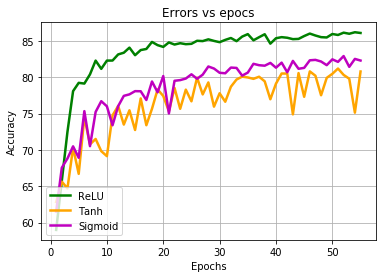

In [32]:
errorPlot()

In [37]:
def layersPlot():
    data=pd.read_csv("../input/assignment5/apparel-trainval.csv").values
    sigmoidError=[]
    reluError=[]
    tanhError=[]
    xlist=[i for i in range(0,3)]
    train,test=splitTrainTest(data,80)#train on 80% data
    oneHotLabelsTrain=getOneHotLabels(train,10)#10 is vector size
    oneHotLabelsTest=getOneHotLabels(test,10)
    trainInputs=train[:,1:]
    testInputs=test[:,1:]
    
    trainInputs=trainInputs/255
    testInputs=testInputs/255

    batchSize=64
    
    for i in xlist:
        print(i)
        numberofLayers=2+i
        
        noofneurons=[724]+[16]*i+[10]
        activationFunctionsRelu=[None]+["relu"]*i+["softmax"]
        activationFunctionsSigmoid=[None]+["sigmoid"]*i+["softmax"]
        activationFunctionsTanh=[None]+["tanh"]*i+["softmax"]
        print(noofneurons,activationFunctionsRelu,numberofLayers)
        nnSigmoid=NeuralNet(numberofLayers,noofneurons,activationFunctionsSigmoid)
        nnRelu=NeuralNet(numberofLayers,noofneurons,activationFunctionsRelu)
        nnTanh=NeuralNet(numberofLayers,noofneurons,activationFunctionsTanh)
        
        nnSigmoid.trainNetwork(trainInputs,oneHotLabelsTrain,batchSize,i,0.6,False)
        nnRelu.trainNetwork(trainInputs,oneHotLabelsTrain,batchSize,i,0.6,False)
        nnTanh.trainNetwork(trainInputs,oneHotLabelsTrain,batchSize,i,0.3,False)
        
        sigmoidError.append(nnSigmoid.getAccuracy(testInputs, oneHotLabelsTest,True))
        reluError.append(nnRelu.getAccuracy(testInputs, oneHotLabelsTest,True))
        tanhError.append(nnTanh.getAccuracy(testInputs, oneHotLabelsTest,True))
        
    plt.title("Errors vs Number of layers")
    plt.xlabel("Hidden Layers (each with 16 neurons)")
    plt.ylabel("Accuracy")
    plt.grid(True)
#     print(xlist,reluError,sigmoidError,tanhError)
    plt.plot(xlist,reluError ,color="green", linewidth=2.5,label="ReLU")
    plt.plot(xlist,tanhError,color="orange", linewidth=2.5,label="Tanh")
    plt.plot(xlist, sigmoidError,color="m", linewidth=2.5,label="Sigmoid")

    plt.legend(loc=3)
    plt.show()

In [38]:
layersPlot()

0
[724, 10] [None, 'softmax'] 2


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 724 is different from 784)

In [ ]:
from IPython.display import HTML
import base64
def create_download_link(df, title = "Download CSV file", filename = "predictions.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))
create_download_link(df)
